In [5]:
!jupyter nbconvert --to script IBMQ_Sim.ipynb

[NbConvertApp] Converting notebook IBMQ_Sim.ipynb to script
[NbConvertApp] Writing 13466 bytes to IBMQ_Sim.py


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import math
import qutip
import pandas as pd
from qiskit.tools.qi.qi import partial_trace
import scipy
from random import shuffle
import random

In [5]:
b=np.load('bars_n_stripes_dataset.npy')


In [14]:
b2=np.transpose(b)


In [24]:
b2[:,:9]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.]])

In [25]:
b2=min_max_norm()
b2[:,:9]=min_max_norm(b2[:,:9], 0,0.5*math.pi)

NameError: name 'min_max_norm' is not defined

# Import Data

## IRIS

In [83]:
#Import and fix IRIS
iris = pd.read_csv('Iris.csv', header=None)
iris=np.array(iris)

iris=np.array(iris)#numericalise the labels

iris[:,4][iris[:,4] == 'setosa']=1
iris[:,4][iris[:,4] == 'versicolor']=2
iris[:,4][iris[:,4] == 'virginica']=3

iris[:,:4]=min_max_norm(iris[:,:4], 0,0.5*math.pi)

In [26]:
def full_tensor(sequence):
    """tensor product of a sequence in the form of a list of arrays""" 
    for k in range(len(sequence)-1):
        if k==0:
            a=sequence[0]
        a=np.array(np.kron(a,sequence[k+1]), dtype=complex)
    return a


def blockshaped(arr, nrows, ncols):
    #taken from online. this splits arrays into blocks of given size as described below. will need for partial tracing
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))



def evaluate_MPS(params, training_data, ancilla,rounding):
    answers=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        psi=np.real(initial_encode(training_data[i,:L],ancilla))
        psi=np.reshape(psi,(2**total,1))
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        for j in range(total-1):
            psi=np.matmul(cnot(j,j+1,total),psi)
            psi=np.matmul(ry(params[total+j],j+1,total),psi)
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(keep_last(psi,total))
        """Stage 4: Calculate Cost"""
        answers[i]=eval_cost(zero_prob,training_data[i,L],rounding)

    total_cost=np.sum(answers)/training_data.shape[0]
    return total_cost

def evaluate_MPS_plotter(params, training_data, ancilla,rounding):
    guesses=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        psi=initial_encode(training_data[i,:L],ancilla)
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        for j in range(total-1):
            psi=np.matmul(cnot(j,j+1,total),psi)
            psi=np.matmul(ry(params[total+j],j+1,total),psi)
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(keep_last(psi,total))
        """Stage 4: Calculate Cost"""
        guesses[i]=1-round(zero_prob)
    return guesses

def evaluate_4TTN(params, training_data, ancilla,rounding):
    answers=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        psi=initial_encode(training_data[i,:L],ancilla)
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        j=0
        psi=np.matmul(cnot(j,j+1,total),psi)
        psi=np.matmul(ry(params[total],j+1,total),psi)
        j=3
        psi=np.matmul(cnot(j,j-1,total),psi)
        psi=np.matmul(ry(params[total+1],j-1,total),psi)
        j=1
        psi=np.matmul(cnot(j,j+1,total),psi)
        psi=np.matmul(ry(params[total+2],j+1,total),psi)        
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(keep_n(psi,total,2))
        """Stage 4: Calculate Cost"""
        answers[i]=eval_cost(zero_prob,training_data[i,L],rounding)
    total_cost=np.sum(answers)/training_data.shape[0]
    return total_cost

def evaluate_4TTN_plotter(params, training_data, ancilla,rounding):
    guesses=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        psi=initial_encode(training_data[i,:L],ancilla)
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        j=0
        psi=np.matmul(cnot(j,j+1,total),psi)
        psi=np.matmul(ry(params[total],j+1,total),psi)
        j=3
        psi=np.matmul(cnot(j,j-1,total),psi)
        psi=np.matmul(ry(params[total+1],j-1,total),psi)
        j=1
        psi=np.matmul(cnot(j,j+1,total),psi)
        psi=np.matmul(ry(params[total+2],j+1,total),psi)        
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(keep_n(psi,total,2))
        """Stage 4: Calculate Cost"""
        guesses[i]=1-round(zero_prob)
    return guesses
    return total_cost

def evaluate_4TTN_closed(params, training_data, ancilla,rounding):
    answers=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        psi=initial_encode(training_data[i,:L],ancilla)
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        
        j=0
        psi=np.matmul(cnot(j,j+1,total),psi)
        psi=np.matmul(ry(params[total],j+1,total),psi)
        j=3
        psi=np.matmul(cnot(j,j-1,total),psi)
        psi=np.matmul(ry(params[total+1],j-1,total),psi)
        j=1
        psi=np.matmul(cnot(j,j+1,total),psi)
        psi=np.matmul(ry(params[total+2],j+1,total),psi)        
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(keep_n(psi,total,2))
        """Stage 4: Calculate Cost"""
        answers[i]=eval_cost(zero_prob,training_data[i,L],rounding)
    total_cost=np.sum(answers)#/training_data.shape[0]
    return total_cost

In [2]:
np.load('bars_n_strips_dataset.npy')

NameError: name 'np' is not defined

# Useful Functions


In [39]:
def evaluate_MPS_double(params, training_data, ancilla,rounding):
    answers=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        #psi=initial_encode(training_data[i,:L],ancilla)
        norm1=(training_data[i,0]**2+training_data[i,1]**2)**0.5
        norm2=(training_data[i,2]**2+training_data[i,3]**2)**0.5
        psi=np.kron(np.array([training_data[i,0]/norm1, training_data[i,1]/norm1]),np.array([training_data[i,2]/norm2, training_data[i,3]/norm2]))
        psi=np.reshape(psi,(2**total,1))
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        psi=np.matmul(cnot(0,1,total),psi)
        for j in range(total):
            psi=np.matmul(ry(params[total+j],j,total),psi)
        psi=np.matmul(cnot(1,0,total),psi)
        
        psi=np.matmul(ry(params[4],0,total),psi)
        dm=np.kron(np.transpose(psi),psi)
        dm=np.reshape(dm,(2**total,2**total))
        dm=partial_trace(dm,[1])
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(dm)
        """Stage 4: Calculate Cost"""
        answers[i]=eval_cost(zero_prob,training_data[i,4],rounding)

    total_cost=np.sum(answers)/training_data.shape[0]
    return total_cost

def evaluate_MPS_double2(params, training_data, ancilla,rounding):
    answers=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        #psi=initial_encode(training_data[i,:L],ancilla)
        norm1=(training_data[i,0]**2+training_data[i,1]**2)**0.5
        norm2=(training_data[i,2]**2+training_data[i,3]**2)**0.5
        psi=np.kron(np.array([training_data[i,0]/norm1, training_data[i,1]/norm1]),np.array([training_data[i,2]/norm2, training_data[i,3]/norm2]))
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(1):
            psi=np.matmul(ry(params[0],0,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        psi=np.matmul(cnot(0,1,total),psi)
        for j in range(1):
            psi=np.matmul(ry(params[1],1,total),psi)
        psi=np.matmul(cnot(1,0,total),psi)
        
        psi=np.matmul(ry(params[2],0,total),psi)
        dm=np.kron(np.transpose(psi),psi)
        dm=np.reshape(dm,(2**total,2**total))
        dm=partial_trace(dm,[1])
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(dm)
        """Stage 4: Calculate Cost"""
        answers[i]=eval_cost(zero_prob,training_data[i,4],rounding)

    total_cost=np.sum(answers)/training_data.shape[0]
    return total_cost

def evaluate_MPS2(params, training_data, ancilla,rounding):
    answers=np.zeros(training_data.shape[0])
    L=training_data.shape[1]-1
    for i in range(training_data.shape[0]):
        """FOR EACH DATA POINT"""
        """Lets Encode the data elements first"""
        
        psi=np.real(initial_encode2(training_data[i,:L],ancilla))
        psi=np.reshape(psi,(2**total,1))
        """Stage 1: Unitaries on all of the qubits, ancilla or not"""
        for j in range(total):
            psi=np.matmul(ry(params[j],j,total),psi)
            """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        for j in range(total-1):
            psi=np.matmul(cnot(j,j+1,total),psi)
            psi=np.matmul(ry(params[total+j],j+1,total),psi)
        """Stage 3: Trace and Measure"""
        zero_prob=prob_zero(keep_last(psi,total))
        """Stage 4: Calculate Cost"""
        answers[i]=eval_cost(zero_prob,training_data[i,L],rounding)

    total_cost=np.sum(answers)/training_data.shape[0]
    return total_cost

In [24]:
xtrain=np.load("ae_x_train.npy")
xtest=np.load("ae_x_test.npy")
ytrain=np.load("ae_y_train.npy")
ytest=np.load("ae_y_test.npy")


In [28]:
easy_iris[:,0]

array([0.34906585039886573, 0.26179938779914963, 0.17453292519943306,
       0.13089969389957462, 0.3054326190990077, 0.47996554429844074,
       0.13089969389957462, 0.3054326190990077, 0.043633231299858466,
       0.26179938779914963, 0.47996554429844074, 0.21816615649929116,
       0.21816615649929116, 0.0, 0.6544984694978735, 0.6108652381980154,
       0.47996554429844074, 0.34906585039886573, 0.6108652381980154,
       0.34906585039886573, 0.47996554429844074, 0.34906585039886573,
       0.13089969389957462, 0.34906585039886573, 0.21816615649929116,
       0.3054326190990077, 0.3054326190990077, 0.39269908169872425,
       0.39269908169872425, 0.17453292519943306, 0.21816615649929116,
       0.47996554429844074, 1.1780972450961722, 0.9162978572970231,
       1.1344640137963142, 0.5235987755982988, 0.9599310885968811,
       0.6108652381980154, 0.8726646259971647, 0.26179938779914963,
       1.0035643198967392, 0.39269908169872425, 0.3054326190990077,
       0.6981317007977319, 0.7

In [45]:
xtest2=np.reshape(xtest,(10000,8))

In [49]:
ae_test=np.zeros(shape=(10000,9))

In [50]:
ae_test[:,:8]=xtest2
ae_test[:,8]=ytest

In [53]:
ae_training=np.load('ae_training.npy.npz')

In [57]:
np.save('ae_test',ae_test)

In [64]:
ae_training[ae_training[:,8]==0][:100,:]
ae_training[ae_training[:,8]!=0]

array([[ 0.44089642,  0.70917171,  0.28559935, ...,  0.48362085,
         0.36177436,  5.        ],
       [ 0.3676576 ,  0.4269428 ,  0.29827464, ...,  0.38662362,
         0.34888777,  4.        ],
       [ 0.30929083,  0.11967061,  0.31250951, ...,  0.92814213,
         0.40425175,  1.        ],
       ..., 
       [ 0.51871461,  0.93525344,  0.20341949, ...,  0.4399597 ,
         0.60655528,  5.        ],
       [ 0.96642524,  0.06569592,  0.47728673, ...,  0.16566738,
         0.0604299 ,  6.        ],
       [ 0.29146796,  0.51308995,  0.06714688, ...,  0.93259466,
         0.20202608,  8.        ]])

In [76]:
learning_zero=np.zeros(shape=(400,9))
learning_zero[:100,:]=ae_training[ae_training[:,8]==0][:100,:]
learning_zero[100:,:]=ae_training[ae_training[:,8]!=0][:300,:]
learning_zero[100:,8]=1

In [92]:
np.save('learning_zero_train',learning_zero)

In [60]:
the_zeros=ae_training[:,ae_training[:,8]==0

1

In [79]:
easy_iris[:,4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1], dtype=object)

In [82]:
learning_zero[:,:8]=min_max_norm(learning_zero[:,:8], 0,0.5*math.pi)

In [112]:
rounding=0
no_qubits=4
ancilla=0
total=no_qubits+ancilla
print(total)
data=iris_hard
data1,data2=shuffle_data(data,8)
params=initialise_params(2*(total)-1)
function=evaluate_MPS2
params=scipy.optimize.minimize(function,params,args=(data1,ancilla,0), method='CG')['x']
print(function(params,data1,ancilla,rounding=1))
function(params,data2,ancilla,rounding=1)

4
0.177966101695


0.0

In [113]:
params/math.pi

array([-0.06157075, -0.06907327,  0.85949674,  0.13377883,  0.26224655,
       -0.19760237, -0.84947991])

In [114]:
data2[:,4]

array([0, 1, 0, 1, 1, 0, 1, 1], dtype=object)

In [52]:
easy_iris_test[:,4]

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype=object)

In [115]:
np.save('NEW_MPS_hardiris_good', params)

In [107]:
params=np.load('NEW_MPS_hardiris_params.npy')
function(params,data2,ancilla,rounding=1)

0.1875

In [91]:
params

array([ 3.64724578,  2.06581556,  0.3612934 , -1.94680781, -1.23262464,
       -0.15211161, -0.361956  , -1.59572411,  1.97289869, -1.365741  ,
        0.34056191,  0.66542607, -0.56977922, -0.53991641,  0.92089025,
       -0.69921607, -2.4248023 ])

In [30]:
learning_zero=np.load('learning_zero_train.npy')

In [93]:
np.save('8MPS_identifyingzero',params)

In [68]:
training_data=easy_iris
for i in range(1):
        norm1=(training_data[i,0]**2+training_data[i,1]**2)**0.5
        print(norm1)
        norm2=(training_data[i,2]**2+training_data[i,3]**2)**0.5
        print(norm2)
        psi=np.kron(np.array([training_data[i,0]/norm1, training_data[i,1]/norm1]),np.array([training_data[i,2]/norm2, training_data[i,3]/norm2]))
        for j in range(total):
                    psi=np.matmul(ry(params[j],j,total),psi)
                    """Stage 2: CNOT plus unitary for N-1 times (cascading)"""
        print(psi)
        psi=np.matmul(cnot(0,1,total),psi)  
        print(psi)
        psi=np.matmul(cnot(1,0,total),psi)
        print(np.matmul(ry(params[0],0,2),psi))

1.0419575436209316
0.12499918559646818
[ 0.12065141 -0.70205738 -0.11886896  0.69168551]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
[ 0.12065141 -0.70205738  0.69168551 -0.11886896]
[[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[-0.92358525  0.15872187 -0.34395305  0.05910973]


In [666]:
easy_iris[:,3]

array([0.06544984694978737, 0.06544984694978737, 0.06544984694978737,
       0.06544984694978737, 0.06544984694978737, 0.19634954084936213,
       0.1308996938995747, 0.06544984694978737, 0.06544984694978737, 0.0,
       0.06544984694978737, 0.06544984694978737, 0.0, 0.0,
       0.06544984694978737, 0.19634954084936213, 0.19634954084936213,
       0.1308996938995747, 0.1308996938995747, 0.1308996938995747,
       0.06544984694978737, 0.19634954084936213, 0.06544984694978737,
       0.26179938779914946, 0.06544984694978737, 0.06544984694978737,
       0.19634954084936213, 0.06544984694978737, 0.06544984694978737,
       0.06544984694978737, 0.06544984694978737, 0.19634954084936213,
       0.8508480103472356, 0.9162978572970231, 0.9162978572970231,
       0.7853981633974483, 0.9162978572970231, 0.7853981633974483,
       0.9817477042468103, 0.5890486225480862, 0.7853981633974483,
       0.8508480103472356, 0.5890486225480862, 0.9162978572970231,
       0.5890486225480862, 0.8508480103472

In [701]:
np.savez('4TTN_iris_hard_params',params)

In [707]:
fake_params=[3.64129925,1.04422998, 2.99327683, 4.18602991,1.3215133,2.78138208,4.68090534]
real_params=[]
for i in fake_params:
    real_params.append(i*2)
print(real_params)
test_data=iris

[7.2825985, 2.08845996, 5.98655366, 8.37205982, 2.6430266, 5.56276416, 9.36181068]


In [713]:
evaluate_4TTN(params,iris_hard,ancilla,rounding=1)

C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:285: ComplexWarning: Casting complex values to real discards the imaginary part


7.0

In [698]:
data=iris_hard_train

C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:313: ComplexWarning: Casting complex values to real discards the imaginary part


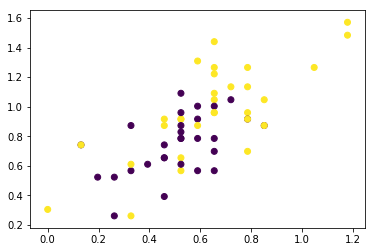

In [699]:
plt.scatter(data[:,1], data[:,0], c=evaluate_4TTN_plotter(params,data,ancilla,rounding=1))
plt.show()

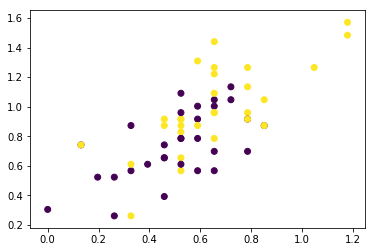

In [700]:
plt.scatter(data[:,1], data[:,0], c=data[:,4])
plt.show()

67

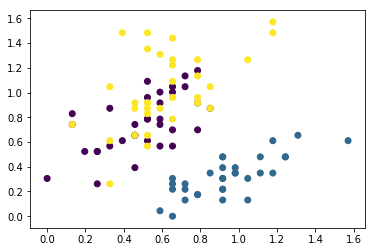

In [478]:
plt.scatter(iris[:,1], iris[:,0], c=iris[:,4])
plt.show()

In [381]:
np.savez('4q_0a_hardiris4',params)

In [331]:
pyplot

array([-1.64627048, -1.64963016, -0.37743302, -0.2764522 ,  0.67576184,
       -1.56552782, -1.50567953])

In [544]:
"""THIS CIRCUIT IS MPS STYLE ONLY"""
total_cost=0
no_qubits=4
ancilla=0
total=ancilla+no_qubits
no_params=(2*total)-1
training_data=easy_iris#_train #remember, labels are data[:,4] here
test_data=iris_hard_test
params=initialise_params(no_params)
cost=np.zeros(training_data.shape[0])
total_cost=evaluate_MPS(params,training_data,ancilla,rounding=0)
print(params)
for p in range(no_params):
    for k in reversed(range(no_params)):
        b=math.pi
        s=-1*math.pi
        n=100
        for z in range(2):
            cost_list=np.zeros(n)

            new_params=np.copy(params)
            candidate_list=np.zeros(n)
            for l in range(n):
                candidate_list[l]=s+((b*(1-l))/n)
                new_params[k]=candidate_list[l]
                cost_list[l]=evaluate_MPS(new_params,training_data,ancilla,rounding=0)
            winner=np.argmin(cost_list)
            if winner==0:
                neighbour=1
            elif winner==n-1:
                neighbour=winner-1
            else:
                if cost_list[winner+1]<cost_list[winner-1]:
                    neighbour=winner+1
                if cost_list[winner-1]<cost_list[winner+1]:
                    neighbour=winner-1

            total_cost=np.min(cost_list)
            params[k]=candidate_list[winner]
            s=np.min([candidate_list[winner],candidate_list[neighbour]])
            b=np.max([candidate_list[winner],candidate_list[neighbour]])
            """if z%2==0:
                iris_hard_train, iris_hard_train=shuffle_data(iris_hard,8)"""
            """delta=1
            for z in range(10):
                up_params=np.copy(params)
                up_params[k]=up_params[k]+np.random.rand()*delta
                up_cost=evaluate_MPS(training_data,up_params,ancilla,rounding=0)
                diff_up=(up_cost-total_cost)
                down_params=np.copy(params)
                down_params[k]=down_params[k]-np.random.rand()*delta
                down_cost=evaluate_MPS(training_data,down_params,ancilla,rounding=0)
                diff_down=(down_cost-total_cost)
                if diff_up<0 and diff_down<0:
                    if diff_up<diff_down:
                        params[k]=up_params[k]
                        new_cost=up_cost
                    elif diff_down<diff_up:
                        params[k]=down_params[k]
                        new_cost=down_cost
                elif diff_up<0 and diff_down>0:
                    params[k]=up_params[k]
                    new_cost=up_cost
                elif diff_up>0 and diff_down<0:
                    params[k]=down_params[k]
                    new_cost=down_cost
                if abs(new_cost-total_cost)<0.1:
                    #print('hey')
                    delta=delta*0.99
                    #print(delta)
                total_cost=new_cost"""
        print('cost is', total_cost)
          #  print('deta is', delta)
        print('rounded cost is',evaluate_MPS(params,training_data,ancilla,rounding=1))
        print('params are', params)

C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:230: ComplexWarning: Casting complex values to real discards the imaginary part


[-0.15498645  0.33141878 -2.35012374 -0.16902831  2.1525246   0.168738
 -2.83295317]
cost is 16.4161533295
rounded cost is 17.0
params are [-0.15498645  0.33141878 -2.35012374 -0.16902831  2.1525246   0.168738
 -1.77311489]
cost is 16.4145275466
rounded cost is 17.0
params are [-0.15498645  0.33141878 -2.35012374 -0.16902831  2.1525246  -6.03185789
 -1.77311489]
cost is 8.25996679307
rounded cost is 12.5
params are [-0.15498645  0.33141878 -2.35012374 -0.16902831 -1.20731406 -6.03185789
 -1.77311489]
cost is 8.18115503606
rounded cost is 12.0
params are [-0.15498645  0.33141878 -2.35012374 -6.22035345 -1.20731406 -6.03185789
 -1.77311489]
cost is 8.14831360336
rounded cost is 12.0
params are [-0.15498645  0.33141878 -2.2396414  -6.22035345 -1.20731406 -6.03185789
 -1.77311489]
cost is 8.14439430729
rounded cost is 12.0
params are [-0.15498645 -5.90619419 -2.2396414  -6.22035345 -1.20731406 -6.03185789
 -1.77311489]
cost is 0.980860460074
rounded cost is 1.0
params are [-1.52430076 -5.9

In [531]:
"""THIS CIRCUIT IS MPS STYLE ONLY"""
total_cost=0
no_qubits=4
ancilla=0
total=ancilla+no_qubits
no_params=(2*total)-1
training_data=easy_iris_train #remember, labels are data[:,4] here
test_data=easy_iris_test
params=initialise_params(no_params)
cost=np.zeros(training_data.shape[0])
total_cost=evaluate_MPS(params,training_data,ancilla,rounding=0)
print(params)
mu=1.5
delta=0.0000000000001
for m in range(2):
    for k in range(no_params):
        for z in range(200):
            new_params=np.copy(params)
            new_params[k]=new_params[k]+delta
            new_cost=evaluate_MPS(new_params,training_data,ancilla,rounding=0)
            diff=new_cost-total_cost
            if abs(diff)>0.1:
                params[k]=params[k]+delta
            if abs(diff)<0.1:
                params[k]=params[k]+delta*mu
        
            total_cost=new_cost
            #print(total_cost)
    print('cost is', total_cost)
      #  print('deta is', delta)
    #print('rounded cost is',evaluate_MPS(params,training_data,ancilla,rounding=1))
    #print('params are', params)

C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:230: ComplexWarning: Casting complex values to real discards the imaginary part


[ 0.74764521 -2.75726401 -0.38224268 -0.25369111 -1.32275994 -3.02131798
  0.15771457]
cost is 1.99774419999
cost is 1.99774419999


In [518]:
params

array([ 1.25866183,  0.03267322, -4.74518949, -0.41616248,  1.12396632,
        1.09980161, -2.44907808])

In [541]:
np.savez('4q_MPS_circuit_iris_hard_params_6_good', params)

In [519]:
print('cost is', total_cost)
print('rounded cost is',evaluate_MPS(params,iris_hard,ancilla,rounding=1))
print('params are', params)
print(params/math.pi)

cost is 1.50029072177
rounded cost is 16.5
params are [ 1.25866183  0.03267322 -4.74518949 -0.41616248  1.12396632  1.09980161
 -2.44907808]
[ 0.4006445   0.01040021 -1.51044073 -0.13246863  0.35776959  0.35007773
 -0.77956577]


C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:230: ComplexWarning: Casting complex values to real discards the imaginary part


In [252]:
print('rounded cost is',evaluate_MPS(test_data,params,ancilla,rounding=1))
print('params are', params)

rounded cost is 0.0
params are [-1.80965737 -4.92182849 -5.75958653 -2.21168123 -3.14159265 -2.19911486
 -2.19911486 -5.90619419 -3.14159265]


C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:228: ComplexWarning: Casting complex values to real discards the imaginary part


In [484]:
params/math.pi

array([-0.38888889, -0.64583333, -0.47288889, -1.        , -1.8       ,
       -1.86666667, -1.1875    ])

In [201]:
b=np.random.rand(10)
np.argmin(b)


3

In [290]:
"""Nelder Mead Style"""

"""THIS CIRCUIT IS MPS STYLE ONLY"""
total_cost=0
no_qubits=4
ancilla=0
total=ancilla+no_qubits
no_params=(2*total)-1
training_data=iris_hard_train #remember, labels are data[:,4] here
test_data=iris_hard_test
alpha=1
beta=0.5
gamma=2
delta=0.5
points=np.zeros((no_params,no_params+1))
point_costs=np.zeros(no_params+1)
for i in range(no_params+1):
    params[i]=initialise_params(no_params)
    point_costs[i]=evaluate_MPS(training_data,params[i],ancilla,rounding=0)

best=np.min(point_costs)
points=points[:,np.argsort(point_costs)
centroid
        
    print('cost is', total_cost)
      #  print('deta is', delta)
    #print('rounded cost is',evaluate_MPS(training_data,params,ancilla,rounding=1))
   # print('params are', params)

'Nelder Mead Style'

In [60]:
cnot(1,0,2)

[[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [26]:
np.savez('2_8_operators_halfhalftraintest_iris.npz',operator_list)

In [ ]:
qutip.Qobj(encode_list(small_iris_train[:,1],2))

In [29]:
qutip.Qobj(operator_list[0])

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[  7.72317552e-01+0.12454335j   2.38265971e-02+0.07587974j
   -1.32811362e-01-0.33812393j  -2.43831934e-02-0.06647168j
    7.49357276e-02-0.08637294j   2.81385648e-02+0.34644238j
   -1.35727303e-01-0.02952267j   3.02226646e-01+0.01361093j]
 [ -8.49203349e-02-0.02352357j   1.70488710e-01+0.10132648j
   -5.40565154e-01-0.22799548j   4.53336814e-01+0.42703022j
   -1.73205422e-02+0.04038379j  -2.19678462e-01+0.02711673j
    1.68859972e-01+0.19712452j  -8.78808448e-02+0.30792923j]
 [ -6.30270595e-02+0.24087556j   4.86260812e-01-0.61332902j
   -1.10264219e-01-0.12371923j  -2.13003682e-01+0.08328247j
   -1.13677738e-01-0.25252312j   3.71710054e-01-0.02065541j
   -4.91513172e-04-0.04783751j  -7.48370839e-02+0.14979481j]
 [  3.48834323e-01+0.10237254j  -1.52006719e-02+0.22831624j
    4.89111648e-02+0.04191805j   2.76366623e-01-0.12996386j
    2.12673406e-01-0.11066391j   4.08207282e-01-0.43964997j
    2.

In [18]:
print("Final Cost with rounding is " ,eval_cost_function(operator_list,data,rounding=1))
print("Test Result without rounding is ", eval_cost_function(operator_list,test_data,rounding=0))
print("Test Result with rounding is ", eval_cost_function(operator_list,test_data,rounding=1))

Final Cost with rounding is  29.0
Test Result without rounding is  11.8525027397
Test Result with rounding is  8.0


In [90]:
eval_cost_function(operator_list,data,rounding=1)

[[ 0.91665696+0.j  0.27640003+0.j]
 [ 0.27640003+0.j  0.08334304+0.j]]
(2, 2)
(0.916656959541+0j)
[[ 0.04468261+0.j -0.20660609+0.j]
 [-0.20660609+0.j  0.95531739+0.j]]
(2, 2)
(0.0446826135725+0j)
[[ 0.13261292+0.j -0.33915592+0.j]
 [-0.33915592+0.j  0.86738708+0.j]]
(2, 2)
(0.132612924568+0j)
[[ 0.88491699+0.j  0.31912209+0.j]
 [ 0.31912209+0.j  0.11508301+0.j]]
(2, 2)
(0.884916991715+0j)
[[ 0.91665696+0.j  0.27640003+0.j]
 [ 0.27640003+0.j  0.08334304+0.j]]
(2, 2)
(0.916656959541+0j)
[[ 0.06922296+0.j -0.25383290+0.j]
 [-0.25383290+0.j  0.93077704+0.j]]
(2, 2)
(0.0692229593031+0j)
[[ 0.98238393+0.j  0.13155128+0.j]
 [ 0.13155128+0.j  0.01761607+0.j]]
(2, 2)
(0.982383934407+0j)
[[ 0.80876231+0.j  0.39327578+0.j]
 [ 0.39327578+0.j  0.19123769+0.j]]
(2, 2)
(0.808762307473+0j)
[[ 0.84881576+0.j  0.35822837+0.j]
 [ 0.35822837+0.j  0.15118424+0.j]]
(2, 2)
(0.848815760567+0j)
[[ 0.96566809+0.j -0.18208029+0.j]
 [-0.18208029+0.j  0.03433191+0.j]]
(2, 2)
(0.965668088726+0j)
[[ 0.09864418+0.j 

50.0

In [305]:
scipy.optimize.minimize(evaluate_MPS(params,training_data,ancilla,rounding=0),params, method='CG')

C:\Users\Abdulah\Anaconda3\lib\site-packages\ipykernel_launcher.py:228: ComplexWarning: Casting complex values to real discards the imaginary part


TypeError: 'numpy.float64' object is not callable

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [300]:
params

array([-0.85032441, -4.92182849, -5.75958653, -4.92182849, -2.63893783,
       -1.04300876, -1.50796447])

In [168]:
N=np.random.rand(4,4)
def trace_last(dm,tracing_out):
    for i in range(tracing_out):
        L=int(dm.shape[0]*0.5)
        a=np.trace(N[0:L,0:L])
        b=np.trace(N[0:L,L:2*L])
        c=np.trace(N[L:2*L,0:L])
        d=np.trace(N[L:2*l,L:2*L])
        l=[a,b,c,d]
        l=np.asarray(l)
        dm=np.reshape(l,(2,2))
    return dm

In [171]:
N

array([[0.05770041, 0.53411366, 0.59571219, 0.55373552],
       [0.4003518 , 0.62921149, 0.64260368, 0.9732211 ],
       [0.23996156, 0.15307084, 0.32869864, 0.13941781],
       [0.98162122, 0.28869923, 0.3299101 , 0.58022901]])

In [184]:
a=np.trace(N[0:2,0:2])
b=np.trace(N[0:2,2:4])
c=np.trace(N[2:4,0:2])
d=np.trace(N[2:4,2:4])
l=[a,b,c,d]
l=np.asarray(l)
print(l)
np.reshape(l,(2,2))

[0.6869119  1.56893328 0.52866079 0.90892765]


array([[0.6869119 , 1.56893328],
       [0.52866079, 0.90892765]])

In [43]:
small_iris[30:45,:]

array([[-2.502624656249496, -2.8797932657906435, 1],
       [-2.6091193224728793, -2.356194490192345, 1],
       [0.7987099966753711, 0.2617993877991492, 2],
       [0.5857206642286054, 0.523598775598299, 2],
       [1.0116993291221368, 0.523598775598299, 2],
       [0.05324733311169127, 0.0, 2],
       [0.6922153304519879, 0.523598775598299, 2],
       [0.5857206642286054, 0.0, 2],
       [0.7987099966753711, 0.7853981633974483, 2],
       [-0.6922153304519886, -0.7853981633974483, 2],
       [0.6922153304519879, 0.0, 2],
       [-0.053247333111691615, 0.2617993877991492, 2],
       [-0.4792259980052228, -0.7853981633974483, 2],
       [0.26623666555845704, 0.523598775598299, 2],
       [0.05324733311169127, -0.7853981633974483, 2]], dtype=object)

In [300]:
# function(normalise) that normalises data appropriately XXX
# function(create_dm) produces initial rho XXXXX
# function(get rid of) ditches the first qubit XXXXX
# function(measure) measures the last qubit (super easy) XXXX
# function(elongate) that tensors a unitary with appropriate sized identity matrix XXXX
# function(initialise) that initialises right number (and size) of unitaries XXXX
# process (optimise) that optimises these unitaries according to a cost function
# process (evaluate) that evaluates the circuit.
z=np.random.rand(5,1)
np.kron(np.transpose(z),z)

array([[ 0.52888268,  0.32374209,  0.16384487,  0.48450909,  0.67869732],
       [ 0.32374209,  0.19817049,  0.10029347,  0.29657993,  0.41544731],
       [ 0.16384487,  0.10029347,  0.05075822,  0.15009819,  0.2102566 ],
       [ 0.48450909,  0.29657993,  0.15009819,  0.44385848,  0.62175419],
       [ 0.67869732,  0.41544731,  0.2102566 ,  0.62175419,  0.87094939]])

In [659]:
print(small_iris[0:10,1].shape)
print(test_iris1.shape)

(10,)
(26,)


# TO DO LIST:

## - check the existing quantum architectures that we are using

## - read on "proper" evolution with unitarity constraints

## - code the circuit

## - try a completely adaptive implementation

## - consider a purely quantum optimisation

In [34]:
A=qutip.rand_unitary(4).full()
A

array([[ 0.67728728-0.04510286j, -0.03767357+0.59710738j,
        -0.07876553+0.07457206j,  0.30078743-0.28116378j],
       [-0.27143852+0.49191928j,  0.63722363+0.34506098j,
         0.14640201+0.2680105j ,  0.2010418 +0.15979529j],
       [-0.04464229-0.0941223j , -0.24845995+0.17756922j,
         0.94572618-0.00818055j, -0.03536123+0.01302057j],
       [-0.28207055-0.36492258j, -0.01999003-0.15251119j,
         0.00643183-0.02157599j,  0.87342314-0.01528317j]])

In [35]:
q,r=np.linalg.qr(A)

In [36]:
np.imag(r)[abs(np.imag(r))<0.000001]=0
np.real(r)[abs(np.real(r))<0.000001]=0
r

array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [37]:
q

array([[-0.67728728+0.04510286j,  0.03767357-0.59710738j,
         0.07876553-0.07457206j, -0.30078743+0.28116378j],
       [ 0.27143852-0.49191928j, -0.63722363-0.34506098j,
        -0.14640201-0.2680105j , -0.2010418 -0.15979529j],
       [ 0.04464229+0.0941223j ,  0.24845995-0.17756922j,
        -0.94572618+0.00818055j,  0.03536123-0.01302057j],
       [ 0.28207055+0.36492258j,  0.01999003+0.15251119j,
        -0.00643183+0.02157599j, -0.87342314+0.01528317j]])

In [56]:
for k in range(0):
    print(k)